### Import dependencies:

- `pandas` and `numpy`: For data manipulation and numerical operations.
- `matplotlib.pyplot`: For data visualization.
- `yfinance`: To fetch stock market data.
- `sklearn.preprocessing`: For feature scaling and data preprocessing.
- `sklearn.linear_model.LinearRegression`: For applying linear regression.
- `sklearn.ensemble.RandomForestRegressor`: For implementing a random forest model.
- `sklearn.model_selection.train_test_split`: To split the dataset into training and testing sets.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

### Define parameters:

- `stocks`: A list of stock tickers representing major e-commerce companies (`AMZN`, `EBAY`, `BABA`, `SHOP`, `WMT`).
- `start_date` and `end_date`: The date range for fetching historical stock data (from September 9, 2019, to December 31, 2022).
- `forecast_weeks`: The number of weeks ahead for which the model will make predictions (set to 8 weeks).

In [4]:
stocks = ["AMZN", "EBAY", "BABA", "SHOP", "WMT"]
start_date = "2011-01-01"
end_date = "2020-01-01"
forecast_weeks = 20

### Fetch stock data:

- The `get_stock_data(stocks)` function retrieves historical adjusted closing prices for the given list of stocks using the `yfinance` library.
- Data is fetched on a **weekly** (`"1wk"`) interval from **September 9, 2019, to December 31, 2022**.
- The function returns a dataframe containing adjusted closing prices for the specified stocks.
- The variable `stock_df` stores the fetched stock data.

In [6]:
def get_stock_data(stocks):
    stock_data = yf.download(stocks, 
                             start = start_date, 
                             end = end_date, 
                             interval = "1wk")['Adj Close']
    return stock_data
stock_df = get_stock_data(stocks = stocks)
stock_df

[*********************100%***********************]  5 of 5 completed


Ticker,AMZN,BABA,EBAY,SHOP,WMT
Date,,,,,
2011-01-01,9.274500,NaN,10.534008,NaN,13.348454
2011-01-08,9.437500,NaN,11.096835,NaN,13.528642
2011-01-15,8.871000,NaN,11.416277,NaN,13.755719
2011-01-22,8.557000,NaN,11.526564,NaN,13.995145
2011-01-29,8.796500,NaN,12.249109,NaN,13.829774
...,...,...,...,...,...
2019-12-16,NaN,204.979721,NaN,39.007000,NaN
2019-12-21,93.489998,NaN,33.083916,NaN,36.983593
2019-12-23,NaN,208.089432,NaN,40.799999,NaN


### Preparing Target Variable for Prediction

This code creates a new DataFrame called `predictions`, which stores the **future adjusted closing prices** for each stock, shifted by `forecast_weeks`.  

#### **Steps:**
1. Iterate over each stock ticker in `stock_df.columns`.
2. Copy the adjusted closing price data for each ticker.
3. Shift the values by `forecast_weeks` to represent future prices.
4. Store the shifted values in the `predictions` DataFrame.
5. Use `dropna(inplace=True)` to remove rows where future prices are unavailable (i.e., at the end of the dataset).

#### **Purpose:**
This transformed dataset will be used as the target variable (`y`) in our machine learning models.

In [8]:
predictions = pd.DataFrame()
for ticker in stock_df.columns:
    adj_close_data = stock_df[ticker].copy()
    predictions[(f"Predict: {ticker}")] = adj_close_data.shift(-forecast_weeks)
predictions.dropna(inplace = True)
predictions

,Predict: AMZN,Predict: BABA,Predict: EBAY,Predict: SHOP,Predict: WMT
Date,,,,,


In [9]:
# stock_df = stock_df.iloc[:-8]

### Data Preparation for Machine Learning Models

This function **`prepare_data(stock_data)`** processes historical stock data to create features and target variables for predictive modeling.

#### **Steps:**
1. Initialize an empty dictionary `prepared_data` to store processed data for each stock.
2. Iterate through each stock ticker in `stock_data.columns`:
   - Create a copy of the stock's historical data.
   - Add a **"Close"** column to store the actual adjusted closing prices.
   - Compute **"Pct_Change"** to capture percentage changes (log returns).
   - Create a **"Prediction"** column by shifting future prices by `forecast_weeks`.
   - Drop any rows containing `NaN` values to ensure data quality.
3. Store the cleaned and transformed DataFrame in the dictionary with the ticker as the key.
4. Return the dictionary containing prepared datasets for all stocks.

#### **Purpose:**
This function structures the stock data for training machine learning models, where:
- **"Pct_Change"** serves as a feature,
- **"Prediction"** is the target variable.

In [11]:
def prepare_data(stock_data):
    prepared_data = {}
    for ticker in stock_data.columns:
        df = stock_data[[ticker]].copy()  # Copy stock data for each ticker
        df["Close"] = df[ticker]  # Actual closing price
        df["Pct_Change"] = df[ticker].pct_change()  # Percentage change (log return)
        df["Prediction"] = df[ticker].shift(-forecast_weeks)  # Target variable: future price
        df = df.dropna()
        prepared_data[ticker] = df
    return prepared_data

In [12]:
stock_data = get_stock_data(stocks)
prepared_data = prepare_data(stock_data)

[*********************100%***********************]  5 of 5 completed
C:\Users\reeto\AppData\Local\Temp\ipykernel_11580\1785719470.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Pct_Change"] = df[ticker].pct_change()  # Percentage change (log return)
C:\Users\reeto\AppData\Local\Temp\ipykernel_11580\1785719470.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Pct_Change"] = df[ticker].pct_change()  # Percentage change (log return)
C:\Users\reeto\AppData\Local\Temp\ipykernel_11580\1785719470.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and wi

### Training and Forecasting Using Machine Learning Models

This code trains **Linear Regression** and **Random Forest** models on historical stock data and makes future price predictions.

#### **Steps:**
1. **Initialize** an empty dictionary `future_predictions` to store forecasts for each stock.
2. **Loop through each stock's prepared dataset**:
   - Define features (`x` - excluding "Prediction" and "Close") and target (`y` - future price).
   - Split data into **training (80%)** and **testing (20%)** sets.
3. **Train Machine Learning Models:**
   - **Linear Regression**: Fit and predict on the test set.
   - **Random Forest Regressor**: Train with 6 estimators and make predictions.
4. **Make Future Predictions:**
   - Extract the last `forecast_weeks` of feature data (`future_x`).
   - Predict future prices using both models.
5. **Store predictions and actual closing prices** in `future_predictions`.

#### **Purpose:**
This process enables stock price forecasting using two different machine learning models. The results help compare the effectiveness of **Linear Regression** and **Random Forest** in predicting future stock prices.


In [14]:
future_predictions = {}
for ticker, df in prepared_data.items():
    x = np.array(df.drop(['Prediction', 'Close'], axis = 1))
    y = np.array(df['Prediction'])
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
    
    # Linear Regression Model
    lin_reg = LinearRegression()
    lin_reg.fit(x_train, y_train)
    lin_reg_preds = lin_reg.predict(x_test)
    
    # Random Forest Model
    rf_reg = RandomForestRegressor(n_estimators = 6, random_state = 42)
    rf_reg.fit(x_train, y_train)
    rf_preds = rf_reg.predict(x_test)
    
    future_x = x[-forecast_weeks:]  # Last 'forecast_weeks' data points
    lin_reg_future_preds = lin_reg.predict(future_x)  # Future predictions with Linear Regression
    rf_future_preds = rf_reg.predict(future_x)  # Future predictions with Random Forest
    
    future_predictions[ticker] = {
        "Linear Regression": lin_reg_future_preds, 
        "Random Forest": rf_future_preds,
        "Actual": df["Close"].iloc[-forecast_weeks : ].values
    }

### Visualization of Stock Price Predictions vs Actual Values

This code generates **comparison plots** for actual and predicted stock prices for each stock in the dataset.

#### **Steps:**
1. **Loop through each stock in `stocks`**:
   - Create a new figure for each stock with a size of **12x6**.
   - Plot the **actual stock prices** with markers `"o"`.
   - Plot **Linear Regression predictions** with a dashed line (`"s"` markers).
   - Plot **Random Forest predictions** with a dotted line (`"^"` markers).
2. **Add Labels and Titles:**
   - Legend to distinguish actual vs. predicted prices.
   - Title indicating stock ticker and the comparison.
   - Labels for X-axis (`Weeks Ahead`) and Y-axis (`Stock Price`).
3. **Show the plots** for visualization.

#### **Purpose:**
This visualization allows for an easy **comparison between actual and predicted stock prices** using both **Linear Regression** and **Random Forest** models. It helps in assessing which model performs better for each stock.


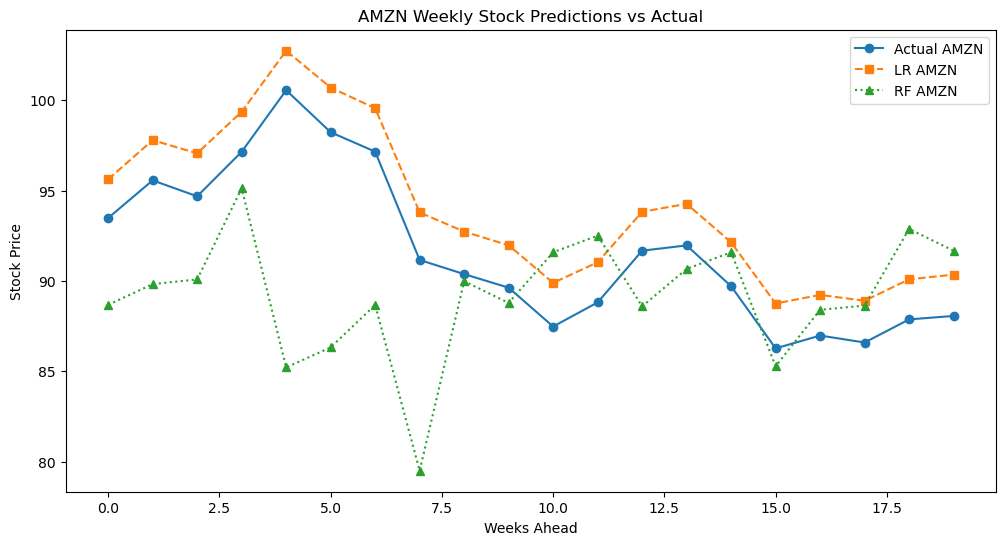

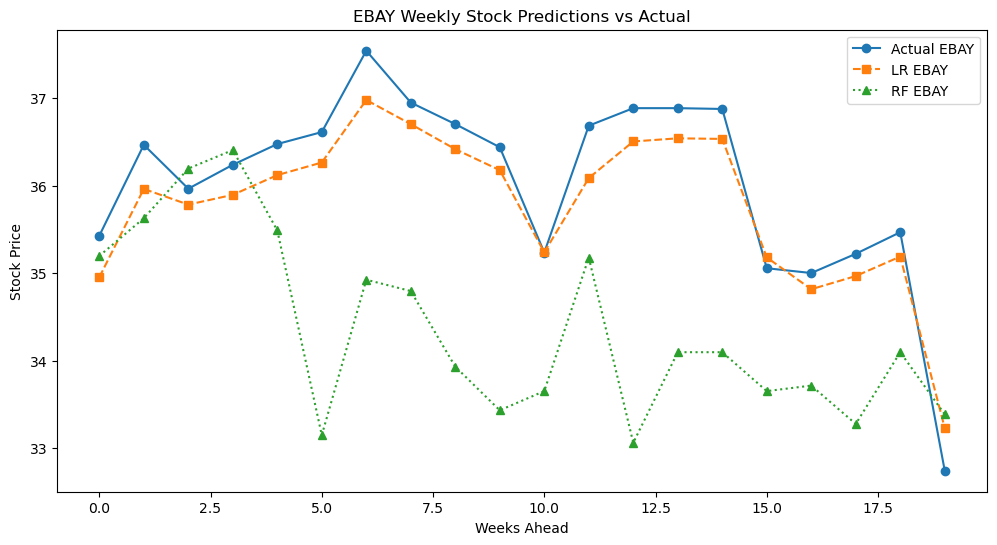

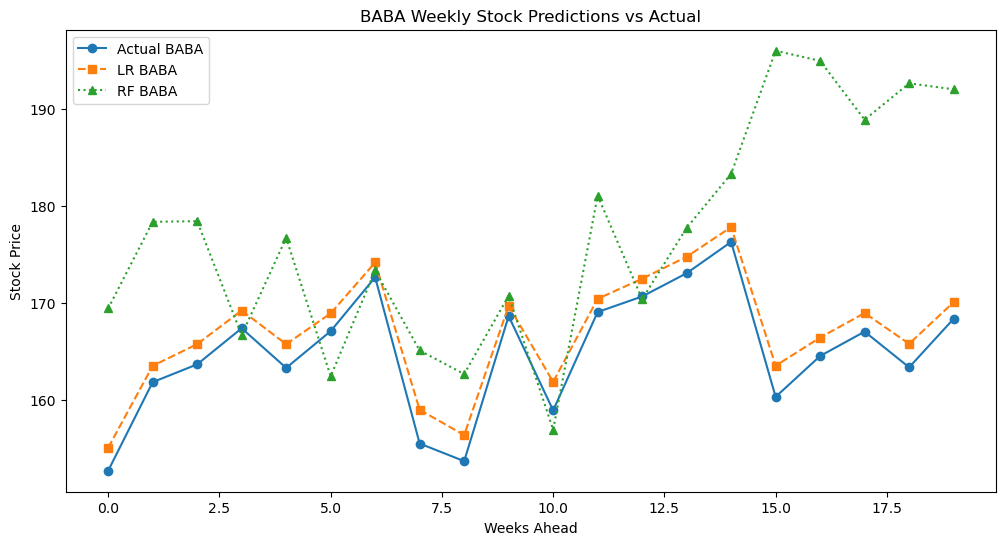

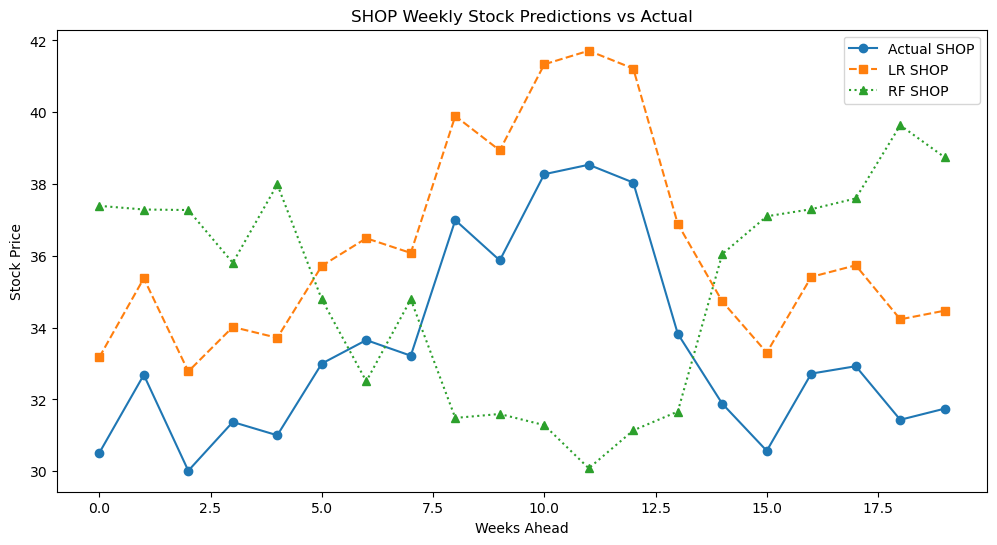

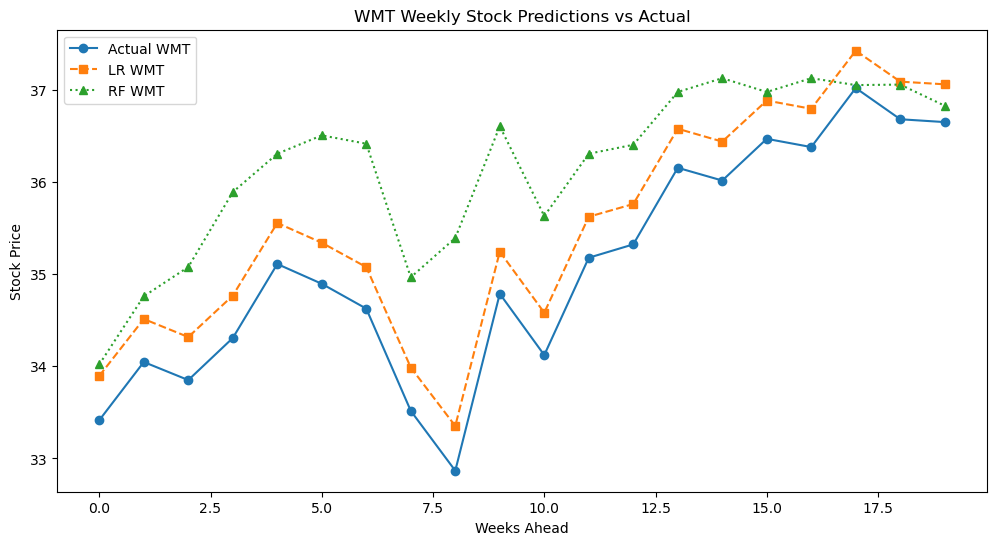

In [16]:
for ticker in stocks:
    plt.figure(figsize = (12, 6))
    plt.plot(future_predictions[ticker]["Actual"], 
             marker = "o", label = f"Actual {ticker}")
    plt.plot(future_predictions[ticker]["Linear Regression"], 
             linestyle = "dashed", marker = "s", label = f"LR {ticker}")
    plt.plot(future_predictions[ticker]["Random Forest"], 
             linestyle = "dotted", marker = "^", label = f"RF {ticker}")
    plt.legend()
    plt.title(f"{ticker} Weekly Stock Predictions vs Actual")
    plt.xlabel("Weeks Ahead")
    plt.ylabel("Stock Price")
    plt.show()

### **Observations: Linear Regression vs. Random Forest Predictions**

The **Linear Regression** model produces forecasts that are **closer in proximity and behavior** to the actual stock prices compared to the **Random Forest** model.

#### **Possible Explanations:**
1. **Linear Trends in Stock Data:**
   - Stock prices often exhibit a degree of **linear trend** over short-term periods.
   - Linear Regression, by nature, captures these trends effectively, making it a suitable model for short-term forecasting.

2. **Overfitting in Random Forest:**
   - Random Forest is a **non-parametric** ensemble method that captures complex patterns and non-linear relationships.
   - It may be **overfitting to past data**, making it less effective for predicting future stock prices, especially when the trend is relatively smooth.

3. **Limited Feature Set:**
   - The model currently uses **percentage change** (`Pct_Change`) as a predictor.
   - Since Linear Regression assumes a direct relationship between input features and output, it is likely benefiting from the simplicity of the dataset.

#### **Takeaways:**
- **Linear Regression** appears to provide a more reliable forecast in this case.
- To improve **Random Forest performance**, consider **adding more features** (e.g., volume, moving averages, macroeconomic indicators).
- Further testing with additional **validation metrics (MSE, RMSE, R²)** could provide deeper insights into model accuracy.